In [159]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

x, y = make_classification(n_samples=20, n_features=2, n_informative=1, n_redundant=0, n_clusters_per_class=1, random_state=42)
x = np.where(x > np.mean(x, axis=0), 1, 0)

df = np.c_[y, x]
N, M = df.shape[0], df.shape[1] - 1

m = 2
def split(df, m):
    return df[df[:, m] > 0.5], df[df[:, m] <= 0.5]

def entropy(df):
    p = df[:, 0].mean()
    return -p * np.log(p + 1e-6) - (1 - p) * np.log(1 - p + 1e-6)

def entropy_split(left, right):
    n1 = left.shape[0]
    n2 = right.shape[0]
    return n1 / (n1 + n2) * entropy(left) + n2 / (n1 + n2) * entropy(right)

def gain(df, m):
    left, right = split(df, m)
    if (left.shape[0] == 0) or (right.shape[0] == 0):
        return 0
    else:
        return entropy(df) - entropy_split(left, right)

def best(df):
    M = df.shape[1] - 1
    try:
        gains = [gain(df, m) for m in range(1, M + 1)]
        if np.sum(gains) == 0:
            return None
        else:
            return np.argmax(gains) + 1
    except:
        return None

def split_best(df):
    try:
        m = best(df)
        return split(df, m), m
    except:
        return (None, None), None

class node:
    def __init__(self, df):
        self.df = df
        self.left = None
        self.right = None
        self.split_on = None

def recursive_split(focus):
    if focus.left is None:
        (left, right), m = split_best(focus.df)
        focus.split_on = m
        if left is not None:
            focus.left = node(left)
            focus.right = node(right)
            recursive_split(focus.left)
            recursive_split(focus.right)

def recursive_split_on(focus, depth=0):
    if focus.split_on is None:
        print(" " * (depth * 4) + f"Depth {depth}: None")
    else:
        print(" " * (depth * 4) + f"Depth {depth}: {focus.split_on}")
        recursive_split_on(focus.left, depth + 1)
        recursive_split_on(focus.right, depth + 1)

def predict_row(row, tree):
    if tree.split_on is None:
        return int(tree.df[:, 0].mean() >= 0.5)
    split_index = tree.split_on - 1  # Adjust for feature index shift
    if row[split_index] > 0.5:
        return predict_row(row, tree.left)
    else:
        return predict_row(row, tree.right)

def predict(df, tree):
    return np.array([predict_row(row, tree) for row in df])

train_df, test_df = df[:15], df[15:]
root = node(train_df)
recursive_split(root)

recursive_split_on(root)

y_train_pred = predict(train_df[:, 1:], root)
y_test_pred = predict(test_df[:, 1:], root)

train_acc = accuracy_score(train_df[:, 0], y_train_pred)
test_acc = accuracy_score(test_df[:, 0], y_test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


Depth 0: 2
    Depth 1: 1
        Depth 2: None
        Depth 2: None
    Depth 1: None
Train Accuracy: 0.9333333333333333
Test Accuracy: 1.0


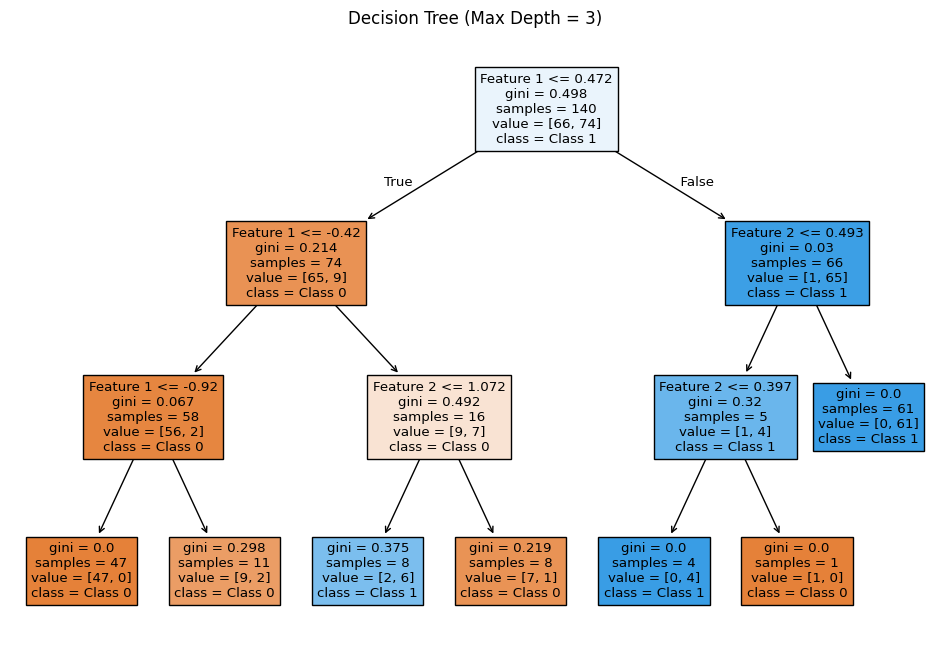

Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        66
           1       0.97      0.96      0.97        74

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140


Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        34
           1       0.86      0.92      0.89        26

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



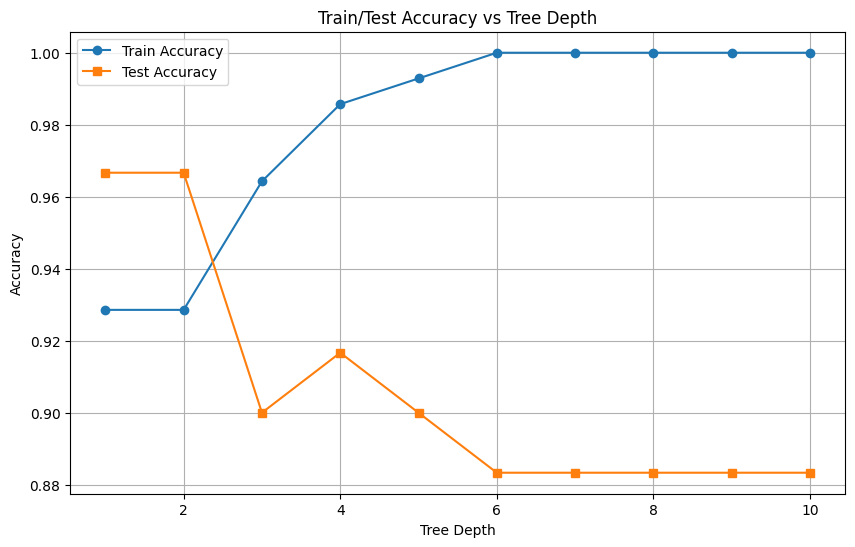

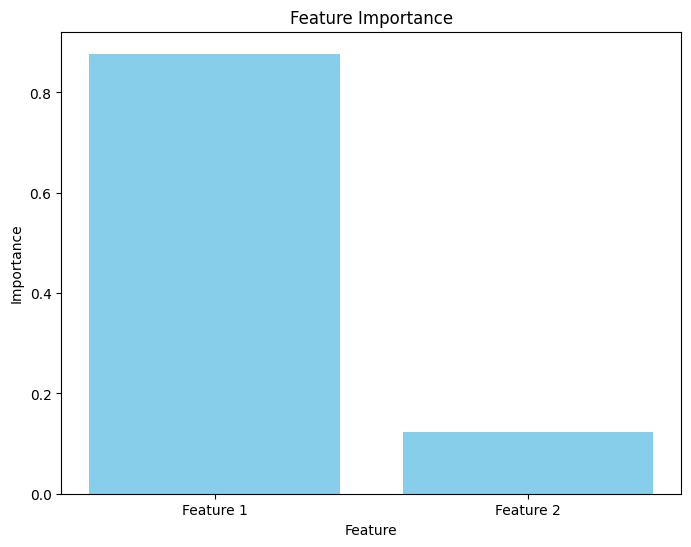

Feature Importances:
Feature 1: 0.8773
Feature 2: 0.1227


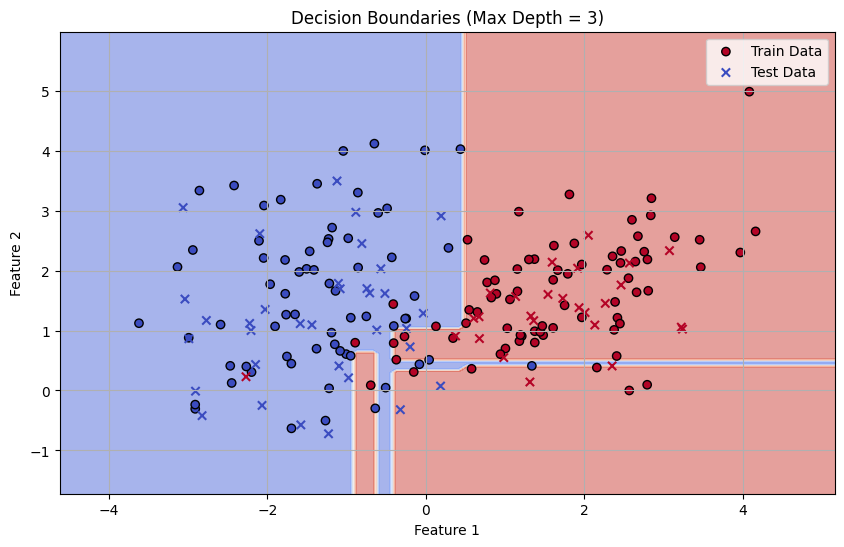

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Step 1: Create a synthetic dataset
np.random.seed(42)
X, y = make_classification(
    n_samples=200, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    class_sep=1.5, 
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Build a decision tree classifier
max_depth = 3  # Adjust depth to visualize its impact
tree_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
tree_clf.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, filled=True, feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"])
plt.title(f"Decision Tree (Max Depth = {max_depth})")
plt.show()

# Step 3: Show classification performance (metrics)
y_pred_train = tree_clf.predict(X_train)
y_pred_test = tree_clf.predict(X_test)

print("Train Classification Report:")
print(classification_report(y_train, y_pred_train))

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test))

# Step 4: Show how train/test error evolves with depth
train_accuracies = []
test_accuracies = []
depths = range(1, 11)

for depth in depths:
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_clf.fit(X_train, y_train)
    train_accuracies.append(accuracy_score(y_train, tree_clf.predict(X_train)))
    test_accuracies.append(accuracy_score(y_test, tree_clf.predict(X_test)))

# Plot train/test accuracies
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Train/Test Accuracy vs Tree Depth")
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Display feature importance
feature_importances = tree_clf.feature_importances_
plt.figure(figsize=(8, 6))
plt.bar(["Feature 1", "Feature 2"], feature_importances, color='skyblue')
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

print("Feature Importances:")
for feature, importance in zip(["Feature 1", "Feature 2"], feature_importances):
    print(f"{feature}: {importance:.4f}")

# Visualize decision boundaries in the feature space
x1_range = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
x2_range = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_grid = np.c_[X1.ravel(), X2.ravel()]

# Predict the class for each point in the grid
y_grid_pred = tree_clf.predict(X_grid)
y_grid_pred = y_grid_pred.reshape(X1.shape)

# Plot decision boundaries
plt.figure(figsize=(10, 6))
plt.contourf(X1, X2, y_grid_pred, alpha=0.5, cmap='coolwarm')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', cmap='coolwarm', label='Train Data')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', cmap='coolwarm', label='Test Data')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title(f"Decision Boundaries (Max Depth = {max_depth})")
plt.legend()
plt.grid(True)
plt.show()


### Questions and Answers

Question: How does a decision tree decide on splits?  
- Answer: Decision trees use impurity measures like Gini index, entropy, or variance reduction to evaluate the quality of splits. The feature and threshold with the highest reduction in impurity are chosen for splitting.

Question: What is the difference between Gini index and entropy?  
- Answer: Both measure impurity:
  - Gini index focuses on class probability:
    \[
    G = 1 - \sum p_i^2
    \]
  - Entropy measures information gain:
    \[
    H = -\sum p_i \log_2(p_i)
    \]
  Gini is computationally simpler, while entropy can handle more nuanced class distributions.

Question: How does tree depth affect decision trees?  
- Answer: Shallow trees (low depth) may underfit, while deep trees (high depth) can overfit. Regularization parameters like `max_depth` help balance this tradeoff.

Question: How do decision trees handle continuous and categorical variables?  
- Answer: Continuous variables are split using thresholds (e.g., \(x \leq t\)), while categorical variables are split into subsets. `sklearn` requires preprocessing for categorical data (e.g., one-hot encoding).

Question: How can decision trees handle missing values?  
- Answer: Surrogate splits route samples with missing values to alternate branches. Alternatively, missing values can be imputed or treated as a separate category.

Question: What is tree pruning, and why is it important?  
- Answer: Pruning reduces tree complexity by removing weak branches. It prevents overfitting and improves generalization. Pre-pruning limits tree growth, and post-pruning removes branches after training.

Question: How is feature importance calculated in decision trees?  
- Answer: Feature importance is based on the total impurity reduction contributed by a feature across all splits. It indicates the relative predictive power of each feature.

Question: How do decision trees handle imbalanced datasets?  
- Answer: Class weights can be adjusted to penalize misclassification of minority classes more heavily. Oversampling, undersampling, or alternative metrics (e.g., AUC-ROC) can also help.

Question: What are surrogate splits in decision trees?  
- Answer: Surrogate splits handle missing values by identifying alternative splits that mimic the behavior of the primary split on the data.

Question: How does regularization improve decision trees?  
- Answer: Regularization limits tree growth by setting parameters like `max_depth`, `min_samples_split`, and `min_samples_leaf`. This helps prevent overfitting while maintaining predictive power.

Question: How do decision trees compare to random forests?  
- Answer: Random forests are ensembles of decision trees. They average predictions from multiple trees, improving stability and reducing overfitting compared to single decision trees.

Question: Why are decision trees prone to overfitting?  
- Answer: Decision trees can grow deeply to perfectly fit the training data, capturing noise and outliers. Regularization and pruning help mitigate this issue.

Question: How are decision boundaries visualized in decision trees?  
- Answer: Decision trees split the feature space into rectangular regions, where each region represents a branch of the tree. Boundaries align with feature thresholds.

Question: How does tree stability impact predictions?  
- Answer: Decision trees are sensitive to small changes in the data, which can result in different splits. Ensembles like random forests improve stability.